   season       date  age         team_played game_type venue  \
0       1  11/1/1996   18  los angeles lakers    season  away   
1       1  11/3/1996   18  los angeles lakers    season  away   
2       1  11/5/1996   18  los angeles lakers    season  home   
3       1  11/6/1996   18  los angeles lakers    season  home   
4       1  11/8/1996   18  los angeles lakers    season  home   

                 opponent win_lose  point_difference game_started  ...  \
0            phoenix suns        w                14         Null  ...   
1  minnesota timberwolves        w                 6            0  ...   
2         new york knicks        w                 6            0  ...   
3       charlotte hornets        l               -10            0  ...   
4         toronto rapters        l                -1            0  ...   

  freethrow_percent offensive_rebounds defensive_rebounds total_rebounds  \
0              Null               Null               Null           Null   
1           

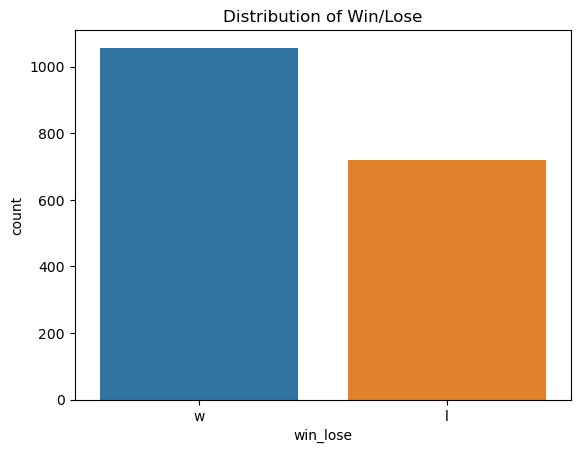

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


df = pd.read_csv('kobebryant.csv') 


print(df.head())

# Check for missing values
print("Missing values:\n", df.isnull().sum())


import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='win_lose', data=df)
plt.title('Distribution of Win/Lose')
plt.show()

In [30]:
from sklearn.preprocessing import LabelEncoder


Missing values:
 season                 0
date                   0
age                    0
team_played            0
game_type              0
venue                  0
opponent               0
win_lose               0
point_difference       0
game_started           0
minutes_played         0
fieldgoal              0
fieldgoal_attempts     0
fieldgoal_percent      7
3pointers              0
3pointers_attempts     0
3pointers_percent     97
freethrows             0
freethrows_attempt     0
freethrow_percent     85
offensive_rebounds     0
defensive_rebounds     0
total_rebounds         0
assists                0
steals                 0
blocks                 0
turnovers              0
personal_fouls         1
points                 1
dtype: int64
   age  win_lose  point_difference minutes_played fieldgoal  \
0   18         1                14           <NA>      Null   
1   18         1                 6       6.366667         0   
2   18         1                 6       3.266667       

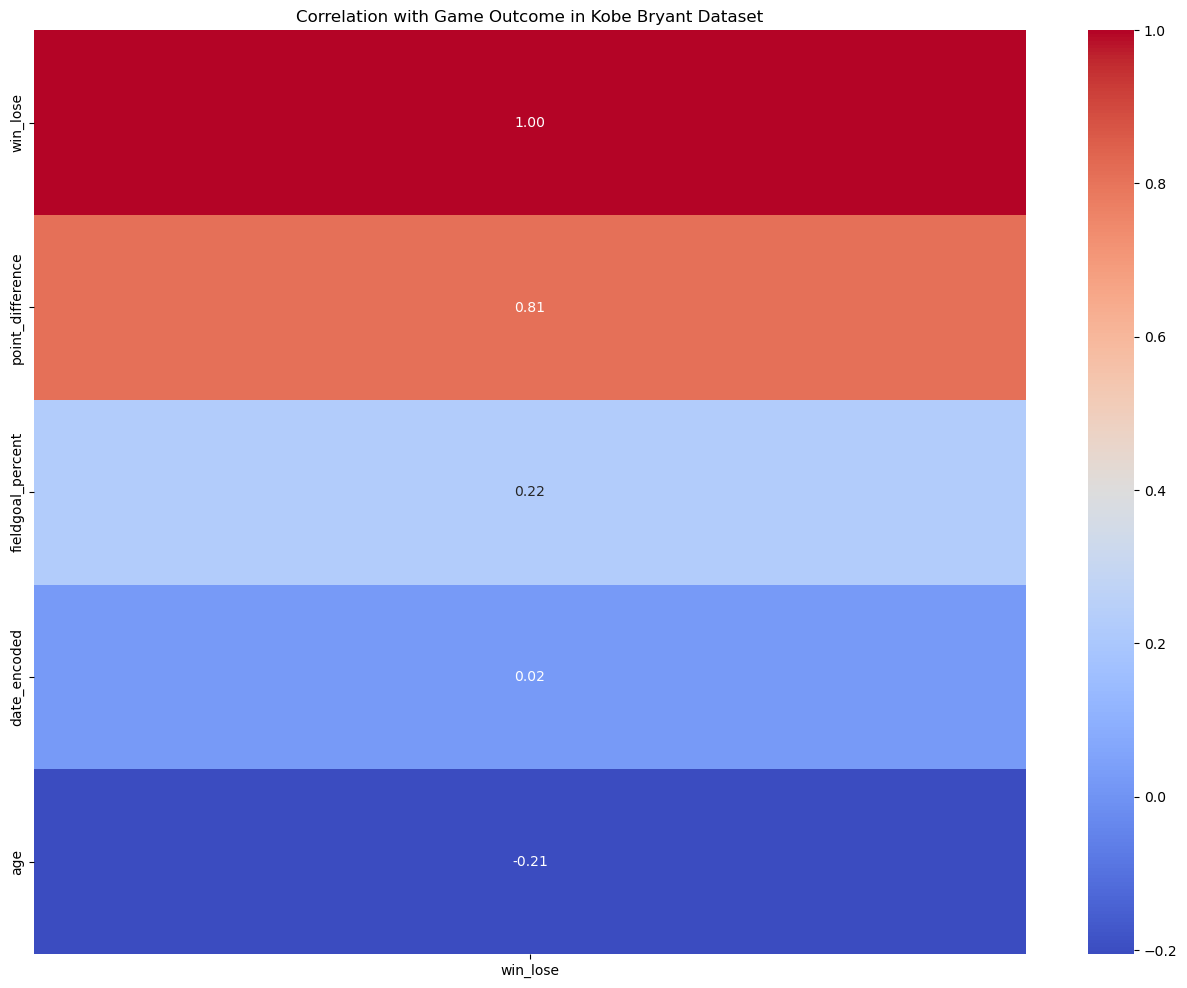

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('kobebryant.csv')

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Preprocessing

# Handle Missing Data
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].replace('Null', pd.NA).apply(pd.to_numeric, errors='coerce')
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Convert 'win_lose' column to numeric
df['win_lose'] = df['win_lose'].map({'w': 1, 'l': 0})

# Convert 'minutes_played' to total minutes played (numeric)
df['minutes_played'] = df['minutes_played'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1])/60 if x != 'Null' else pd.NA)

# Convert 'fieldgoal_percent' to numeric
df['fieldgoal_percent'] = df['fieldgoal_percent'].replace('Null', pd.NA).apply(pd.to_numeric, errors='coerce')

# Encoding Categorical Variables
categorical_cols = ['season', 'team_played', 'game_type', 'venue', 'opponent', 'game_started']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Drop the 'date' column if it exists
if 'date' in df_encoded.columns:
    # Convert 'date' to numerical or extract features
    label_encoder = LabelEncoder()
    df_encoded['date_encoded'] = label_encoder.fit_transform(df_encoded['date'])
    
    # Drop the original 'date' column
    df_encoded = df_encoded.drop(['date'], axis=1)
else:
    print("'date' column not found in df_encoded.")

# Standardizing Numerical Features
scaler = StandardScaler()

# Filter out non-numeric columns
numerical_cols = [col for col in numeric_cols if col in df_encoded.columns]

# Ensure that there are no remaining non-numeric values

# Replace 'Null' with NaN
df.replace('Null', np.nan, inplace=True)

# Fill missing values with median for numerical columns
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Fill missing values with mode for categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Display the first few rows of the encoded dataframe
print(df_encoded.head())

# Visualization

# Convert 'fieldgoal_percent' to numeric
df_encoded['fieldgoal_percent'] = pd.to_numeric(df_encoded['fieldgoal_percent'], errors='coerce')

# Select numeric columns for correlation analysis
numeric_cols_corr = df_encoded.select_dtypes(include=['number']).columns

# Correlation Analysis
correlation_matrix = df_encoded[numeric_cols_corr].corr()

# Visualization
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix[['win_lose']].sort_values(by='win_lose', ascending=False),
            cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation with Game Outcome in Kobe Bryant Dataset')
plt.show()



In [32]:
# Identify numeric and non-numeric columns
numeric_cols = X_train.select_dtypes(include=['number']).columns
non_numeric_cols = X_train.select_dtypes(exclude=['number']).columns

# Convert non-numeric columns to strings
X_train[non_numeric_cols] = X_train[non_numeric_cols].astype(str)
X_test[non_numeric_cols] = X_test[non_numeric_cols].astype(str)

# Create transformers for numeric and non-numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

non_numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', non_numeric_transformer, non_numeric_cols),
    ]
)

# Append classifier to preprocessing pipeline
rf_classifier = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', RandomForestClassifier(random_state=42))])

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)


Accuracy: 0.98
Confusion Matrix:
 [[138   1]
 [  5 212]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       139
           1       1.00      0.98      0.99       217

    accuracy                           0.98       356
   macro avg       0.98      0.98      0.98       356
weighted avg       0.98      0.98      0.98       356

